In [1]:
# Skewt code
# This serves as an intensive exercise of matplotlib's transforms
# and custom projection API. This example produces a so-called
# SkewT-logP diagram, which is a common plot in meteorology for
# displaying vertical profiles of temperature. As far as matplotlib is
# concerned, the complexity comes from having X and Y axes that are
# not orthogonal. This is handled by including a skew component to the
# basic Axes transforms. Additional complexity comes in handling the
# fact that the upper and lower X-axes have different data ranges, which
# necessitates a bunch of custom classes for ticks,spines, and the axis
# to handle this.

from matplotlib.axes import Axes
import matplotlib.transforms as transforms
import matplotlib.axis as maxis
import matplotlib.spines as mspines
import matplotlib.path as mpath
from matplotlib.projections import register_projection
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# The sole purpose of this class is to look at the upper, lower, or total
# interval as appropriate and see what parts of the tick to draw, if any.

class SkewXTick(maxis.XTick):
    def draw(self, renderer):
        if not self.get_visible(): return
        renderer.open_group(self.__name__)

        lower_interval = self.axes.xaxis.lower_interval
        upper_interval = self.axes.xaxis.upper_interval

        if self.gridOn and transforms.interval_contains(
                self.axes.xaxis.get_view_interval(), self.get_loc()):
            self.gridline.draw(renderer)

        if transforms.interval_contains(lower_interval, self.get_loc()):
            if self.tick1On:
                self.tick1line.draw(renderer)
            if self.label1On:
                self.label1.draw(renderer)

        if transforms.interval_contains(upper_interval, self.get_loc()):
            if self.tick2On:
                self.tick2line.draw(renderer)
            if self.label2On:
                self.label2.draw(renderer)

        renderer.close_group(self.__name__)


# This class exists to provide two separate sets of intervals to the tick,
# as well as create instances of the custom tick
class SkewXAxis(maxis.XAxis):
    def __init__(self, *args, **kwargs):
        maxis.XAxis.__init__(self, *args, **kwargs)
        self.upper_interval = 0.0, 1.0

    def _get_tick(self, major):
        return SkewXTick(self.axes, 0, '', major=major)

    @property
    def lower_interval(self):
        return self.axes.viewLim.intervalx

    def get_view_interval(self):
        return self.upper_interval[0], self.axes.viewLim.intervalx[1]


# This class exists to calculate the separate data range of the
# upper X-axis and draw the spine there. It also provides this range
# to the X-axis artist for ticking and gridlines
class SkewSpine(mspines.Spine):
    def _adjust_location(self):
        trans = self.axes.transDataToAxes.inverted()
        if self.spine_type == 'top':
            yloc = 1.0
        else:
            yloc = 0.0
        left = trans.transform_point((0.0, yloc))[0]
        right = trans.transform_point((1.0, yloc))[0]

        pts  = self._path.vertices
        pts[0, 0] = left
        pts[1, 0] = right
        self.axis.upper_interval = (left, right)


# This class handles registration of the skew-xaxes as a projection as well
# as setting up the appropriate transformations. It also overrides standard
# spines and axes instances as appropriate.
class SkewXAxes(Axes):
    # The projection must specify a name.  This will be used be the
    # user to select the projection, i.e. ``subplot(111,
    # projection='skewx')``.
    name = 'skewx'

    def _init_axis(self):
        #Taken from Axes and modified to use our modified X-axis
        self.xaxis = SkewXAxis(self)
        self.spines['top'].register_axis(self.xaxis)
        self.spines['bottom'].register_axis(self.xaxis)
        self.yaxis = maxis.YAxis(self)
        self.spines['left'].register_axis(self.yaxis)
        self.spines['right'].register_axis(self.yaxis)

    def _gen_axes_spines(self):
        spines = {'top':SkewSpine.linear_spine(self, 'top'),
                  'bottom':mspines.Spine.linear_spine(self, 'bottom'),
                  'left':mspines.Spine.linear_spine(self, 'left'),
                  'right':mspines.Spine.linear_spine(self, 'right')}
        return spines

    def _set_lim_and_transforms(self):
        """
        This is called once when the plot is created to set up all the
        transforms for the data, text and grids.
        """
        rot = 30

        #Get the standard transform setup from the Axes base class
        Axes._set_lim_and_transforms(self)

        # Need to put the skew in the middle, after the scale and limits,
        # but before the transAxes. This way, the skew is done in Axes
        # coordinates thus performing the transform around the proper origin
        # We keep the pre-transAxes transform around for other users, like the
        # spines for finding bounds
        self.transDataToAxes = self.transScale + (self.transLimits +
                transforms.Affine2D().skew_deg(rot, 0))

        # Create the full transform from Data to Pixels
        self.transData = self.transDataToAxes + self.transAxes

        # Blended transforms like this need to have the skewing applied using
        # both axes, in axes coords like before.
        self._xaxis_transform = (transforms.blended_transform_factory(
                    self.transScale + self.transLimits,
                    transforms.IdentityTransform()) +
                transforms.Affine2D().skew_deg(rot, 0)) + self.transAxes

# Now register the projection with matplotlib so the user can select
# it.
register_projection(SkewXAxes)

# stub for plotting skewt diagram
def my_SkewPlot(p, t, td, show=True):
    
    fig = plt.figure(figsize=(6.5875, 6.2125))
    ax = fig.add_subplot(111, projection='skewx')

    plt.grid(True)

    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dicatated by the typical meteorological plot
    ax.semilogy(t, p, 'r')
    ax.semilogy(td, p, 'g')

    # An example of a slanted line at constant X
    l = ax.axvline(0, color='b')

    # Disables the log-formatting that comes with semilogy
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_yticks(np.linspace(100,1000,10))
    ax.set_ylim(1050,100)

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.set_xlim(-50,50)

    if show:
        plt.show()

#-----------------------------------------------------------------------------
# Plot function for 2D time/height plots

def plot_time_height(x, y, fld, clevels, cmap=cm.jet, ax=None, **kwargs):

    from mpl_toolkits.axes_grid1.anchored_artists import AnchoredText

    if ax == None:
        plt.figure(figsize = (8,8))
        ax = plt.subplot(111)

    plotf   = ax.contourf(x, y, fld, clevels, cmap=cmap)
    plot    = ax.contour(x, y, fld, clevels[::2], color='k')
    divider = make_axes_locatable(ax)
    cax     = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(plotf, cax=cax)
    if "main" in kwargs:
        ax.set_title(kwargs['main'])

    if "ylabel" in kwargs:
        ax.set_ylabel(kwargs['ylabel'])

    if "xlabel" in kwargs:
        ax.set_xlabel(kwargs['xlabel'])       
        
    at = AnchoredText("Fld_Max: %4.1f \nFld_Min: %4.1f" % (fld.max(),fld.min()), \
                      loc=2, prop=dict(size=10), frameon=True,)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)



In [25]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

_nz    = 60

# parameters for the initial forcing
_fmag   = 0.1
_fdepth = 1000.
_ftime  = 200.

# Set up some parameters
rk3       = [0.33333333, 0.5, 1.0]
dt        = 2.0
dz        = 250.
integrate = 3600.
nstep     = np.int(integrate/dt)
grav      = 9.806
Cp        = 1004.
Rgas      = 287.04
C_radius  = 5000.
entrainR  = 0.1
cloud_time = np.zeros((nstep,))


#-----------------------------------------------------------------------------
# subroutines for initialization and advection
#
def zgrid(nz, height = 15000., stag=False): 
    dz = height / np.float(nz)
    if stag:
        dz = height / np.float(nz)
        return np.arange(nz+1)*dz
    else:
        return (np.arange(nz)+0.5)*dz

#-----------------------------------------------------------------------------
#
def sounding(gz, qv_sfc = 14.):
    
    #define parameters
    theta_sfc  = 300.
    z_trop     = 12000.
    theta_trop = 343.
    temp_trop  = 213.
    
    # compute theta profile
    theta = 0.0*gz
    t1    = theta_sfc + (theta_trop - theta_sfc)*((gz/z_trop)**1.25)
    t2    = theta_trop * np.exp(grav * (gz - z_trop) / (Cp * temp_trop))   
    theta = np.where(gz <= z_trop, t1, t2)
    
    # compute rh profile
    rh    = np.where(gz <= z_trop, 1.0 - 0.75*((gz/z_trop)**1.25), 0.25)
    
    # integrate hydrostatic eq
    pi    = 0.0*gz
    p     = 0.0*gz
    pi[0] = 1.0 - 0.5*dz*grav/(Cp*theta_sfc)
    
    for k in np.arange(1,gz.shape[0]):
        pi[k] = pi[k-1] - 2.0*dz*grav/(Cp*(theta[k-1]+theta[k]))
    
    # compute pressure (Pa) profile
    p = 1.0e5 * pi**(3.5088)
    t = pi*theta - 273.16
    
    # compute qv profile
    qvs = (380./p) * np.exp(17.27*((pi*theta - 273.16)/(pi*theta-36.)))
    qv  = qvs*rh
    qv  = np.where( qv > qv_sfc/1000., qv_sfc/1000., qv)
    
    # recompute RH so that it reflects the new qv_sfc limit - needed to dewpoint computation.
    rh  = qv/qvs
    
    ess = 6.112 * np.exp(17.67 * t / (t + 243.5))
    val = np.log(rh * ess/6.112)
    td  = 243.5 * val / (17.67 - val)
    
    den = p / (t+273.16 * Rgas)
    
    return pi, theta, qv, p, t, td, den

#-----------------------------------------------------------------------------
# compute fake buoyancy forcing
#
def buoyancy(t, t0, qv, qv0, qc, qr):

    return grav*((t/t0 - 1.0) + 0.61*(qv - qv0) - qc - qr )

#-----------------------------------------------------------------------------
# compute buoyancy forcing
#
def fake_buoyancy0(fmag, time, gz):

    A_t  = np.sin(np.pi*time/300)
    
    A_z  = np.sin(np.pi*(gz/(gz[-1]-gz[0])))**2
        
    return 0.1*A_t*A_z

#-----------------------------------------------------------------------------
# compute buoyancy forcing
#
def fake_buoyancy(fmag, time, gz):

    A_t  = np.sin(np.pi*time/_ftime)
    
    if time > _ftime:
        return 0.0
    
    A_z  = np.sin(np.pi*(gz/(_fdepth)))**2
    
    A_z  = np.where(gz > 2.0*_fdepth, 0.0, A_z)
    
    return fmag*A_t*A_z

#-----------------------------------------------------------------------------
# compute horizontal [velocity field / dx] -> units of 1/sec
#
def continuity(w, den, dz):
        
    den_w = 0.0*w  # make same size as w for fluxes
    
    den_w[1:-1] = w[1:-1]*(0.5*(den[0:-1] + den[1:]))
        
    # create average velocity
    return  (den_w[1:] - den_w[0:-1]) / (dz*den)
 
#-----------------------------------------------------------------------------
# compute terminal velocity
#
def compute_vt(qr, den):
                
    # create average velocity
    return  31.25*(0.001*den*qr)**0.125

#-----------------------------------------------------------------------------
# entrain
#
def compute_entrain(var, w, env_var = None):
    
    if env_var == None:  # create 0.0 field same size
        env_var = 0.0*var
        
    if var.shape[0] != w.shape[0]:   # this deals with staggering...
        wvelo = 0.5*(w[1:]+w[0:-1])
    else:
        wvelo = w
            
    # entrainment....
    return  - entrainR * (var - env_var) * np.abs(wvelo) / C_radius


#-----------------------------------------------------------------------------
# compute vertical advection of w
#
def w_advect(w, dz):
    
    w_avg = 0.0*w  # make it same size as w to simplify code indices
    dwdt  = 0.0*w  # make it same size as w to simplify code indices
    
    # create average velocity
    w_avg[1:-1] = 0.25*(w[0:-2] + 2.0*w[1:-1] + w[2:])
    
    dwdt[2:-3] = -(w_avg[2:-3]/(12.*dz)) * (-w[4:-1] + 8.0*w[3:-2]               - 8.0*w[1:-4] + w[0:-5]) \
             - abs(w_avg[2:-3]/(12.*dz)) * ( w[4:-1] - 4.0*w[3:-2] + 6.0*w[2:-3] - 4.0*w[1:-4] + w[0:-5])

#     dwdt[2:-3]  = - (w_avg[2:-3]/(2.*dz)) * (w[3:-2] - w[1:-4])

    dwdt[1]     = - w_avg[ 1] * 0.5 * (w[2] - w[1] ) / dz
    dwdt[-2]    = - w_avg[-1] * 0.5 * (w[-1]- w[-2]) / dz
    
    return dwdt

#-----------------------------------------------------------------------------
# compute vertical advection of scalars
#
def s_advect(w, s, dz):
    
    w_avg = 0.0*s  # make it same size as scalar array to simplify code indices
    dsdt  = 0.0*s # make it same size as scalar array to simplify code indices
    
    # create average velocity
    w_avg[0:-1] = 0.5*(w[0:-2] + w[1:-1])
     
    dsdt[2:-3] = -(w_avg[2:-3]/(12.*dz)) * (-s[4:-1] + 8.0*s[3:-2]               - 8.0*s[1:-4] + s[0:-5]) \
             - abs(w_avg[2:-3]/(12.*dz)) * ( s[4:-1] - 4.0*s[3:-2] + 6.0*s[2:-3] - 4.0*s[1:-4] + s[0:-5])

#     dthdt[2:-3]  = - (w_avg[2:-3]/(2.*dz)) * (th[3:-2] - th[1:-4])

    # assume zero-gradient BC's
    dsdt[ 0] = - w_avg[ 0] * 0.5 * (s[ 1] - s[ 0]) / dz
    dsdt[ 1] = - w_avg[ 1] * 0.5 * (s[ 2] - s[ 0]) / dz
    dsdt[-2] = - w_avg[-2] * 0.5 * (s[-1] - s[-3]) / dz
    dsdt[-1] = - w_avg[-1] * 0.5 * (s[-1] - s[-2]) / dz
    
    return dsdt
    

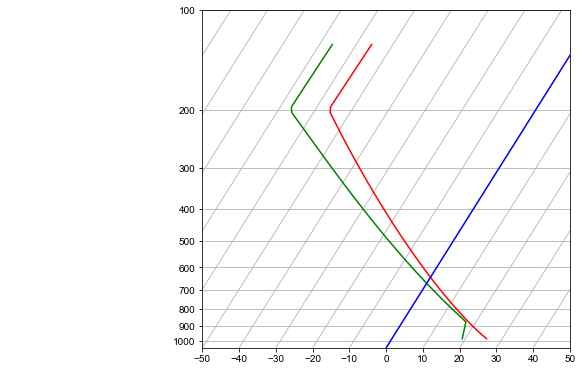

In [26]:
# Initialization Cell

# Create vertical grid
gz         = zgrid(_nz)
gz_w       = zgrid(_nz, stag=True)
cloud_time = np.zeros((nstep,))

# compute WK soundng

pi0, th0, qv0, p0, t0, td0, r0 = sounding(gz)

# plot skewt
my_SkewPlot(p0/100., t0, td0)




300.0 18.726133844 0.0
300.0 19.0666641347 0.0
300.0 391.333878865 300.139057906


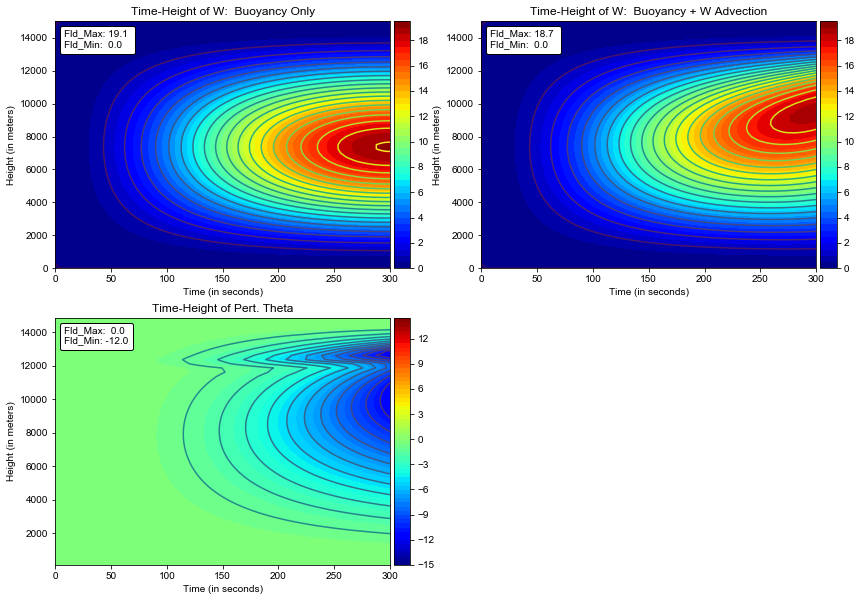

In [27]:
nlen = 12

cloud_time = np.zeros((nstep/nlen,))


# W 
w2d  = np.zeros((_nz+1, nstep/nlen))

# W buoyancy only
wb2d = np.zeros((_nz+1, nstep/nlen))

# W buoyancy only
tb2d = np.zeros((_nz, nstep/nlen))
tb2d[:,0] = th0

# Main time loop for assignment #1
for n in np.arange(1,nstep/nlen):
    
    # first copy old value into new to start calculation
    w2d[ :,n] = w2d[ :,n-1]
    wb2d[:,n] = wb2d[:,n-1]

    # RK steps
    for m in np.arange(3):
        dts  = rk3[m]*dt
        time = n*dt + dts
        
        # Compute buoyancy
        b = fake_buoyancy0(_fmag, time, gz)
            
        # Compute w_advection
        w_adv = w_advect(w2d[:,n], dz)
        
        # Compute th_)advection
        th_adv = s_advect(w2d[:,n], tb2d[:,n], dz)


        # Make RK step  
        w2d [1:-1,n] = w2d[1:-1,n-1]  + dts * ((b[0:-1]+b[1:])/2.0 + w_adv[1:-1])
        wb2d[1:-1,n] = wb2d[1:-1,n-1] + dts * ((b[0:-1]+b[1:])/2.0)
        tb2d[:,n]    = tb2d[:,n-1]    + dts * th_adv[:]
    
    cloud_time[n]    = time
        
print time, w2d.max(), w2d.min()
print time, wb2d.max(), wb2d.min()
print time, tb2d.max(), tb2d.min()

# Plotting stuff

w_clevels  = np.arange(0, 20, 0.5)
th_clevels = -15. + np.arange(0, 30, 0.5)

plt.figure(figsize = (14,10))

ax = plt.subplot(221)


plot_time_height(cloud_time, gz_w, wb2d, w_clevels, ax=ax, cmap=cm.jet, \
                 main='Time-Height of W:  Buoyancy Only',
                 xlabel='Time (in seconds)',
                 ylabel='Height (in meters)')

ax = plt.subplot(222)

plot_time_height(cloud_time, gz_w, w2d, w_clevels, ax=ax, cmap=cm.jet, \
                 main='Time-Height of W:  Buoyancy + W Advection',
                 xlabel='Time (in seconds)',
                 ylabel='Height (in meters)')

ax = plt.subplot(223)

th_plot = tb2d[:,:] - th0.reshape(_nz,1)

plot_time_height(cloud_time, gz, th_plot, th_clevels, ax=ax, cmap=cm.jet, \
                 main='Time-Height of Pert. Theta',
                 xlabel='Time (in seconds)',
                 ylabel='Height (in meters)')
plt.show()


In [28]:
# Main Integration loop.....
from kessler1d import kessler

cloud_time = np.zeros((nstep))



# Initialize 2D (height,time) arrays

# Theta
th2d      = np.zeros((_nz, nstep))
th2d[:,0] = th0

# QV
qv2d      = np.zeros((_nz, nstep))
qv2d[:,0] = qv0

# Qc
qc2d      = np.zeros((_nz, nstep))

# Qc
qr2d      = np.zeros((_nz, nstep))

# W 
w2d  = np.zeros((_nz+1, nstep))

# Main time loop
for n in np.arange(1,nstep):
    
    # first copy old value into new to start calculation
    w2d[ :,n] = w2d[ :,n-1]
    th2d[:,n] = th2d[:,n-1]

    # RK steps
    for m in np.arange(3):
        dts  = rk3[m]*dt
        time = n*dt + dts
        
        # Compute buoyancy
        b = buoyancy(th2d[:,n], th0, qv2d[:,n], qv0, qc2d[:,n],qr2d[:,n]) + fake_buoyancy(_fmag, time, gz)
            
        # Compute w_advection
        w_adv = w_advect(w2d[:,n], dz)

        # Compute th_)advection
        th_adv = s_advect(w2d[:,n], th2d[:,n], dz)

        # Compute qv_advection
        qv_adv = s_advect(w2d[:,n], qv2d[:,n], dz)

        # Compute qc_advection
        qc_adv = s_advect(w2d[:,n], qc2d[:,n], dz)

        # Compute qr_advection
        qr_adv = s_advect(w2d[:,n], qr2d[:,n], dz)

        # Compute lateral entrainment velocity
        u = continuity(w2d[:,n], r0, dz)

        # Compute entrainment
        w_entr  = compute_entrain(w2d[:,n], w2d[:,n])
        th_entr = compute_entrain(th2d[:,n], w2d[:,n], env_var = th0)
        qv_entr = compute_entrain(qv2d[:,n], w2d[:,n], env_var = qv0)
        qc_entr = compute_entrain(qc2d[:,n], w2d[:,n])
        qr_entr = compute_entrain(qr2d[:,n], w2d[:,n])


        # Make RK step  
        w2d [1:-1,n] = w2d[1:-1,n-1]  + dts * ((b[0:-1]+b[1:])/2.0 + w_adv[1:-1] + w_entr[1:-1])
        th2d[:,n]    = th2d[:,n-1]    + dts * (th_adv[:] + th_entr[:])
        qv2d[:,n]    = qv2d[:,n-1]    + dts * (qv_adv[:] + qv_entr[:])
        qc2d[:,n]    = qc2d[:,n-1]    + dts * (qc_adv[:] + qc_entr[:])
        qr2d[:,n]    = qr2d[:,n-1]    + dts * (qr_adv[:] + qr_entr[:])
 
    # Do microphysics on large time step
    t1  = th2d[:,n].copy()
    qv1 = qv2d[:,n].copy()
    qc1 = qc2d[:,n].copy()
    qr1 = qr2d[:,n].copy()

    kessler(t1, qv1, qc1, qr1, th0, pi0, dt, dz)

    th2d[:,n] = t1
    qv2d[:,n] = qv1
    qc2d[:,n] = qc1
    qr2d[:,n] = qr1
        
    cloud_time[n]    = time
        
print time, w2d.max(), w2d.min()
print time, th2d.max(), th2d.min()
print time, 1000*qv2d.max(), 1000*qv2d.min()
print time, 1000*qc2d.max(), 1000*qc2d.min()
print time, 1000*qr2d.max(), 1000*qr2d.min()

/Users/Louis.Wicker/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:142: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


3600.0 66.9954769955 -40.2418754591
3600.0 391.333878865 297.663163731
3600.0 15.4354484344 0.000241443150215
3600.0 4.74218387716 -3.16238121844e-09
3600.0 0.298220161342 0.0


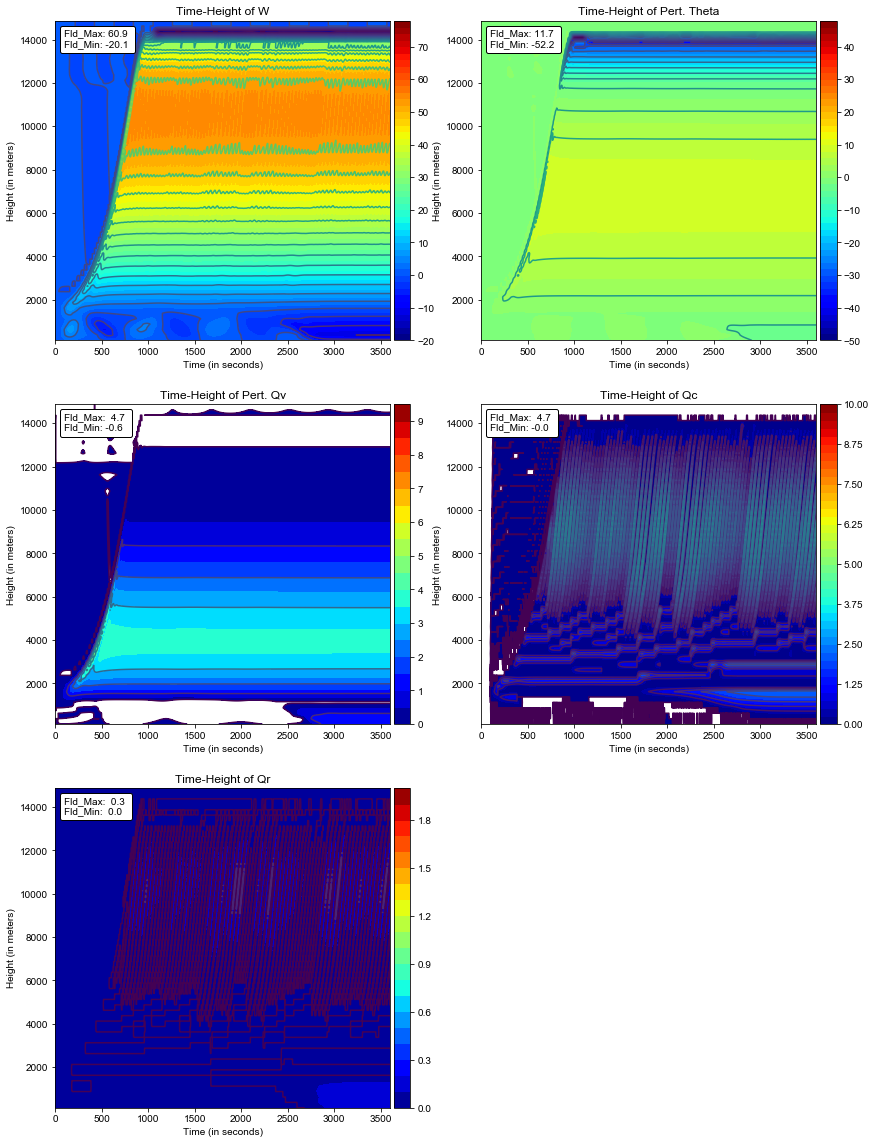

In [31]:

# Plotting stuff

w_clevels  = -20 + np.arange(0, 100, 2.0)
th_clevels = -50. + np.arange(0, 100, 2.0)
qv_clevels = np.arange(0, 10, 0.5)
qc_clevels = np.arange(0, 10.25,0.25)
qr_clevels = np.arange(0, 2.1, 0.1)


plt.figure(figsize = (14,20))

ax = plt.subplot(321)

w_plot = 0.5*(w2d[1:,:]+w2d[0:-1,:])

plot_time_height(cloud_time, gz, w_plot, w_clevels, ax=ax, cmap=cm.jet, \
                 main='Time-Height of W',
                 xlabel='Time (in seconds)',
                 ylabel='Height (in meters)')

ax = plt.subplot(322)

th_plot = th2d[:,:] - th0.reshape(_nz,1)

plot_time_height(cloud_time, gz, th_plot, th_clevels, ax=ax, cmap=cm.jet, \
                 main='Time-Height of Pert. Theta',
                 xlabel='Time (in seconds)',
                 ylabel='Height (in meters)')

ax = plt.subplot(323)

qv_plot = 1000*(qv2d[:,:] - qv0.reshape(_nz,1))

plot_time_height(cloud_time, gz, qv_plot, qv_clevels, ax=ax, cmap=cm.jet, \
                 main='Time-Height of Pert. Qv',
                 xlabel='Time (in seconds)',
                 ylabel='Height (in meters)')

ax = plt.subplot(324)

qc_plot = 1000.*np.where(qc2d < 0.0, 0.0, qc2d)

plot_time_height(cloud_time, gz, 1000*qc2d, qc_clevels, ax=ax, cmap=cm.jet, \
                 main='Time-Height of Qc',
                 xlabel='Time (in seconds)',
                 ylabel='Height (in meters)')

ax = plt.subplot(325)

qr_plot = 1000.*np.where(qr2d < 0.0, 0.0, qr2d)

plot_time_height(cloud_time, gz, 1000*qr2d, qr_clevels, ax=ax, cmap=cm.jet, \
                 main='Time-Height of Qr',
                 xlabel='Time (in seconds)',
                 ylabel='Height (in meters)')


plt.show()